# Batch dispersion analysis

## Initialise session and load data

In [10]:
%run src_ipynb/init.ipynb

import pandas as pd
from os.path import dirname, join, abspath, exists
from os import getcwd, pardir, walk
from os import getcwd, walk, mkdir


import numpy as np
import matplotlib.pyplot as plot
import pickle
import matplotlib.colors
from src.models.formulas import smooth
from IPython.display import display, HTML

%run src_ipynb/load_data.ipynb

Saved updated sensor names and dumped into /Users/macoscar/Documents/04_Projects/02_FabLab/01_SmartCitizen/01_Repositories/DataAnalysis/smartcitizen-iscape-data/data/interim/sensorNames.json


HTML(value='<h2>Test load</h2>')

interactive(children=(SelectMultiple(description='Test', layout=Layout(width='600px'), options={'2017-06_INT_F…

HTML(value='<hr>')

Output()

## Input options

In [2]:
import pandas as pd
from os.path import dirname, join, abspath
from os import getcwd, pardir

# INPUT DATA
# Name of test to be analysed
dispersion_test = 'HASSELT'
# How to export the files ('png' or 'fig' or None)
type_file = None
# number_of_measurements/limit to be considered NG sensor
limit_errors = 10
# Multiplier for std_dev (sigma)
limit_confidence_sigma = 3
# Use average dispersion or instantaneous
use_instantatenous_dispersion = False
# Min/max date for the analysis
min_date = None
max_date = None
# In case there is a device with lower amount of channels, ignore the missing channels and keep going
ignore_missing_channels = True
# Smooth channels
smooth_channels = True
smooth_number = 15
# ----------   

## Get list of common channels
Displays a warning in case there is a device that has fewer channels than the rest. You can choose whether or not to ignore it or update the list of common channels

In [4]:
# Get list of common channels
save_path = join(records.rootDirectory, 'data/export/figs', dispersion_test)
# Test Path
if not exists(save_path):
    print ('Creating export directory:\n{}'.format(save_path))
    mkdir(save_path)

list_channels = list()
# Get list of devices
list_devices = list(records.readings[dispersion_test]['devices'].keys())
# Init list of common channels. Get the one that has the most
list_channels = records.readings[dispersion_test]['devices'][list_devices[0]]['data'].columns
# Extract list of common channels
len_channels = len(list_channels)

for device in records.readings[dispersion_test]['devices']:
    
    if ignore_missing_channels: 
        # We don't reduce the list in case the new list is smaller
        list_channels = list(set(list_channels) | set(records.readings[dispersion_test]['devices'][device]['data'].columns))
    else:
        # We reduce it
        list_channels = list(set(list_channels) & set(records.readings[dispersion_test]['devices'][device]['data'].columns))

    print ('Device {}'.format(device))
    print ('\tMin reading at {}'.format(records.readings[dispersion_test]['devices'][device]['data'].index[0]))
    print ('\tMax reading at {}'.format(records.readings[dispersion_test]['devices'][device]['data'].index[-1]))
    print ('\tNumber of points {}'.format(len(records.readings[dispersion_test]['devices'][device]['data'].index)))
    ## Eliminate devices with no points
    if (len(records.readings[dispersion_test]['devices'][device]['data'].index) == 0):
        print ('Droping device {} for insufficient data points'.format(device))
        records.readings[dispersion_test]['devices'].pop(device)
    # Check the number of channels    
    elif len_channels != len(records.readings[dispersion_test]['devices'][device]['data'].columns): 
        print("\tWARNING: Device {} has {}. Current common list length is {}".format(device, len(records.readings[dispersion_test]['devices'][device]['data'].columns), len_channels))
        len_channels = len(list_channels)
        if ignore_missing_channels:
            print ("\tIgnoring missing channels")

print('Final list of channels:\n', list_channels)

if min_date != None: min_date = min_date.tz_localize('UTC').tz_convert('Europe/Madrid')
if max_date != None: max_date = max_date.tz_localize('UTC').tz_convert('Europe/Madrid')

Device 10014
	Min reading at 2019-09-17 10:36:00+02:00
	Max reading at 2019-09-17 15:09:00+02:00
	Number of points 274
Final list of channels:
 ['EXT_PM_25', 'CCS811_ECO2', 'NOISE_A', 'LIGHT', 'PRESS', 'BATT', 'CCS811_VOCS', 'EXT_PM_10', 'TEMP', 'EXT_PM_1', 'HUM']


In [6]:
display(HTML('<h1>Test Report</h1>'))
display(HTML('<hr>'))
display(HTML('<h2>Summary</h2>'))
display(HTML('<p><strong>Test name:</strong> {}</p>'.format(dispersion_test)))
display(HTML('<p><strong>Number of devices tested:</strong> {}</p>'.format(len(list_devices))))
display(HTML('<p><strong>Test date:</strong> {}</p>'.format('2019-09-19')))
display(HTML('<p><strong>Test author:</strong> {}</p>'.format('Óscar González')))

In [7]:
# Calculate the dispersion for the sensors present in the dataset
dispersion_df = pd.DataFrame()
dispersion_history = list()
display(HTML('<h3>Warnings</h3>'))
warning_displayed = False
for channel in list_channels:
    
    list_columns = list()
    if channel != 'BATT':
        for device in list_devices:
            if channel in records.readings[dispersion_test]['devices'][device]['data'].columns:
                # Important to resample and bfill for unmatching measures
                if smooth_channels:
                    channel_new = records.readings[dispersion_test]['devices'][device]['data'][channel].resample('1Min').bfill().rolling(window=smooth_number).mean()
                    dispersion_df[channel + '-' + device] = channel_new
                else:
                    dispersion_df[channel + '-' + device] = records.readings[dispersion_test]['devices'][device]['data'][channel].resample('1Min').bfill()
                
                list_columns.append(channel + '-' + device)
    
                # Trim dataset to min and max dates (normally these tests are carried out with _minutes_ of differences)
                if min_date != None: dispersion_df = dispersion_df[dispersion_df.index > min_date]
                if max_date != None: dispersion_df = dispersion_df[dispersion_df.index < max_date]
            else:
                display(HTML('<p>WARNING: Device {} does not contain {}</p>'.format(device, channel))) 
                warning_displayed = True
    # Calculate Metrics
    dispersion_df[channel + '_AVG'] = dispersion_df.loc[:,list_columns].mean(skipna=True, axis = 1)
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
            
    # Calculate Metrics
    dispersion_global = dispersion_df[channel + '_STD'].mean()
    # print (dispersion_df.index[0], dispersion_df.index[-1], channel, dispersion_global)
    dispersion_history.append([channel, dispersion_global, limit_confidence_sigma])
if not warning_displayed:
    display(HTML('<p>No warning for this test</p>'.format(device, channel))) 
    
# display(HTML('<h3>Sensor dispersion</h3>'))
# display(HTML('<p>Below, the sensor dispersion for each channel is listed (units of each sensor)</p>'))
# dispersion_history = tuple(dispersion_history)
# display(HTML('<ul style="list-style-type:disc;">'))
# for item in dispersion_history:
#     display(HTML('<li>{}: {}</li>'.format(item[0], item[1])))
# display(HTML('</ul>'))


## Conclusions

Devices show normal behaviour. 
- One faulty device for temperature/humidity sensor (SHT31) detected (9967)
- One device had the PM sensor unplugged (9977)
- One device was tested further to assess learning period of CSS811 (9974)

### Historic data 
For low amount of kits (<15)

In [ ]:
## Channel, dev, sigma
dispersion_history = (['NOISE_A', 1.4985941320690142, limit_confidence_sigma],
                      ['TEMP', 0.402864267636, limit_confidence_sigma],
                      ['HUM', 1.093261343673646, limit_confidence_sigma],
                      ['PM_1', 1.0993547541085011, limit_confidence_sigma],
                      ['PM_10', 1.8032029938488807, limit_confidence_sigma],
                      ['PM_25', 1.5317464142148285, limit_confidence_sigma],
                      ['EXT_PM_1', 1.0993547541085011, limit_confidence_sigma],
                      ['EXT_PM_10', 1.8032029938488807, limit_confidence_sigma],
                      ['EXT_PM_25', 1.5317464142148285, limit_confidence_sigma],
                      ['PRESS', 0.09164764646778648, limit_confidence_sigma],
                      ['LIGHT', 4.296821068348175, limit_confidence_sigma],
                      ['CCS811_VOCS', 2.4695145652624584, limit_confidence_sigma],
                      ['CCS811_ECO2', 18.211133488940373, limit_confidence_sigma])

## Time Series Plot

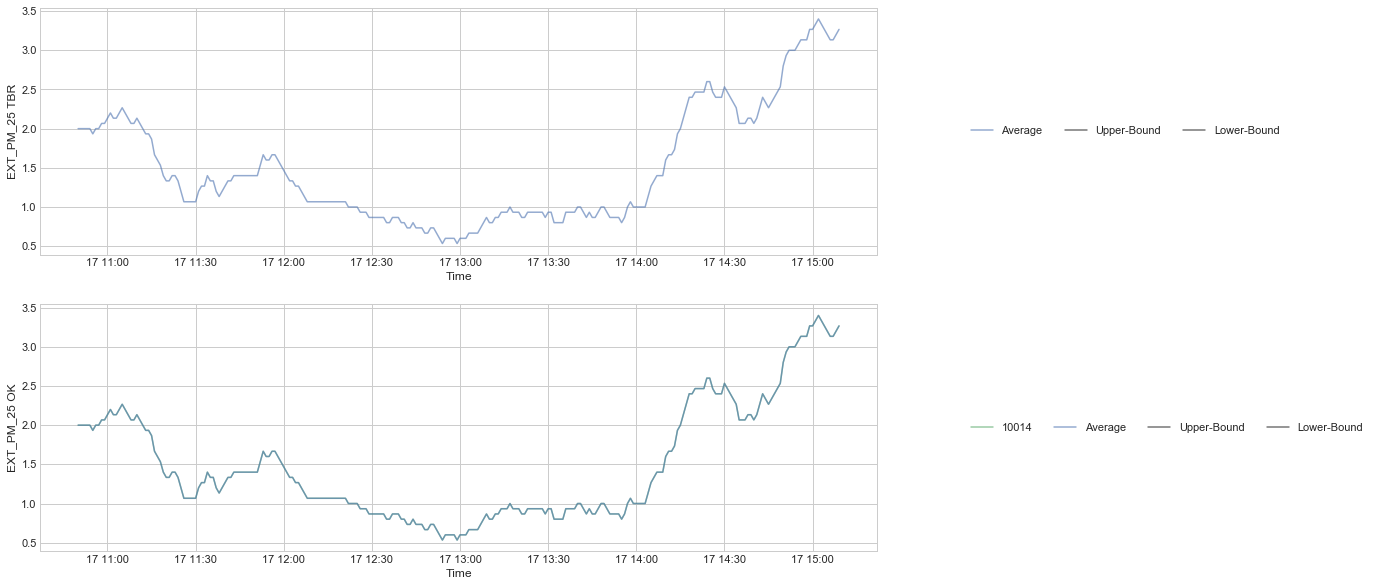

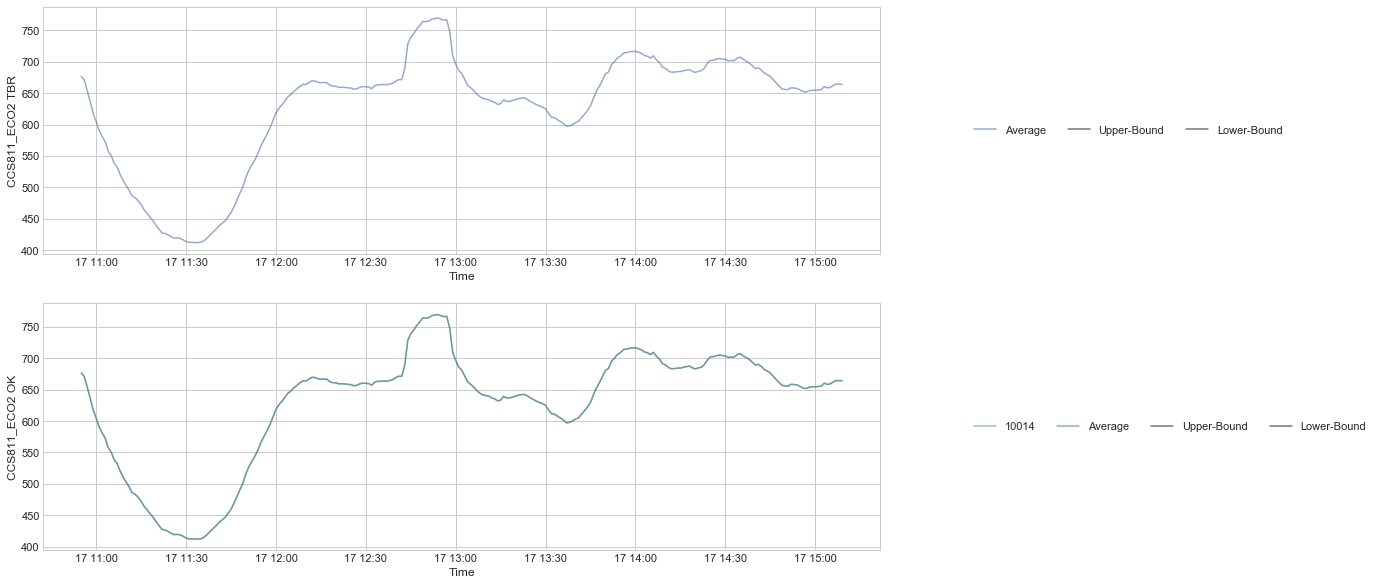

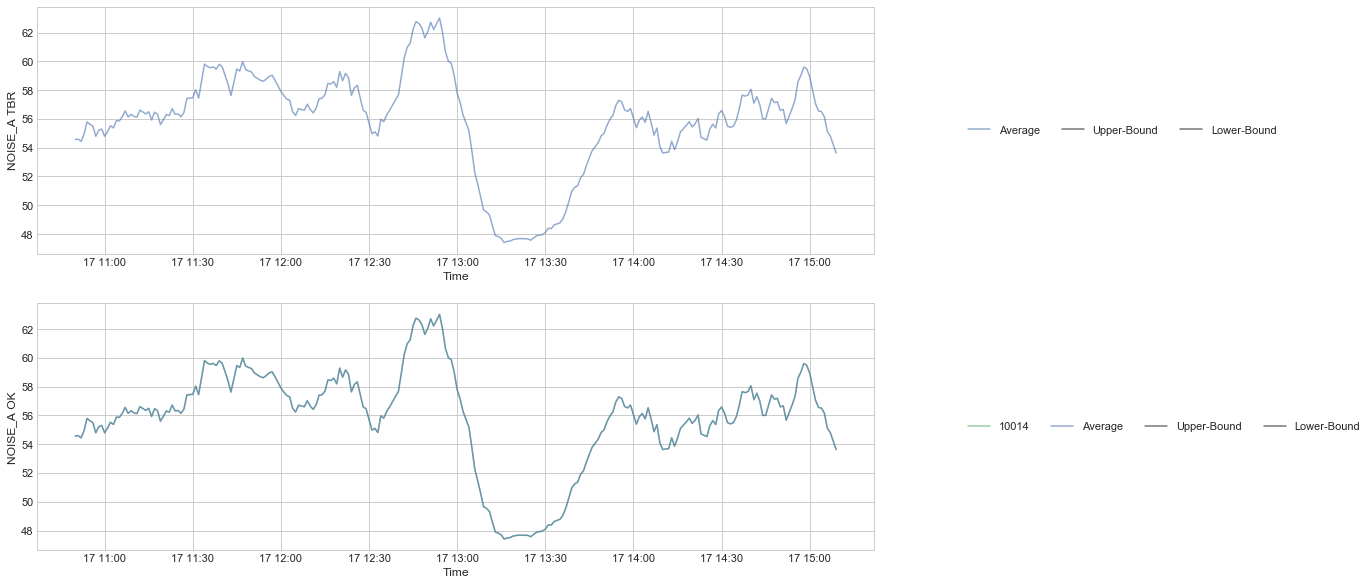

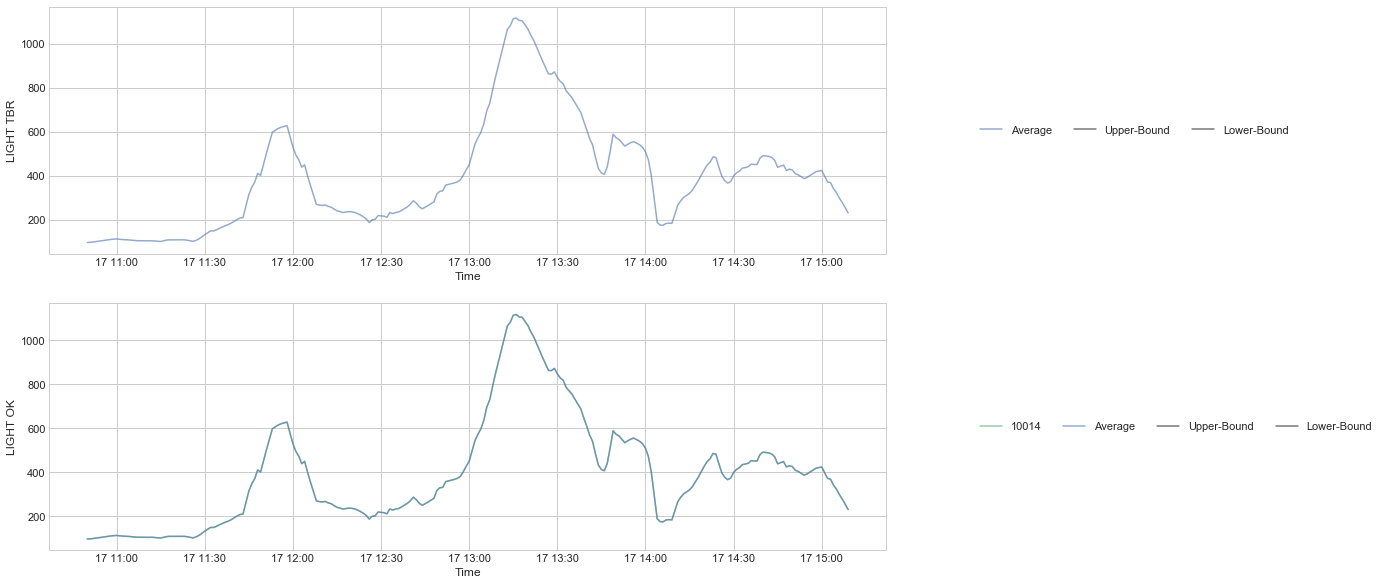

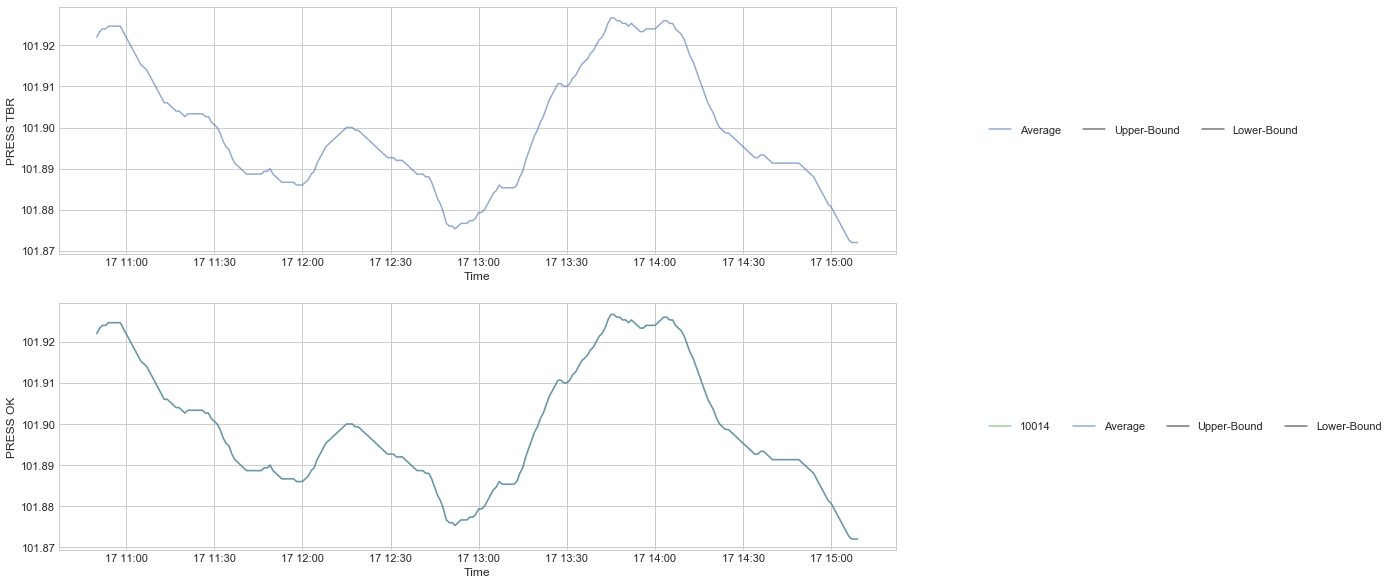

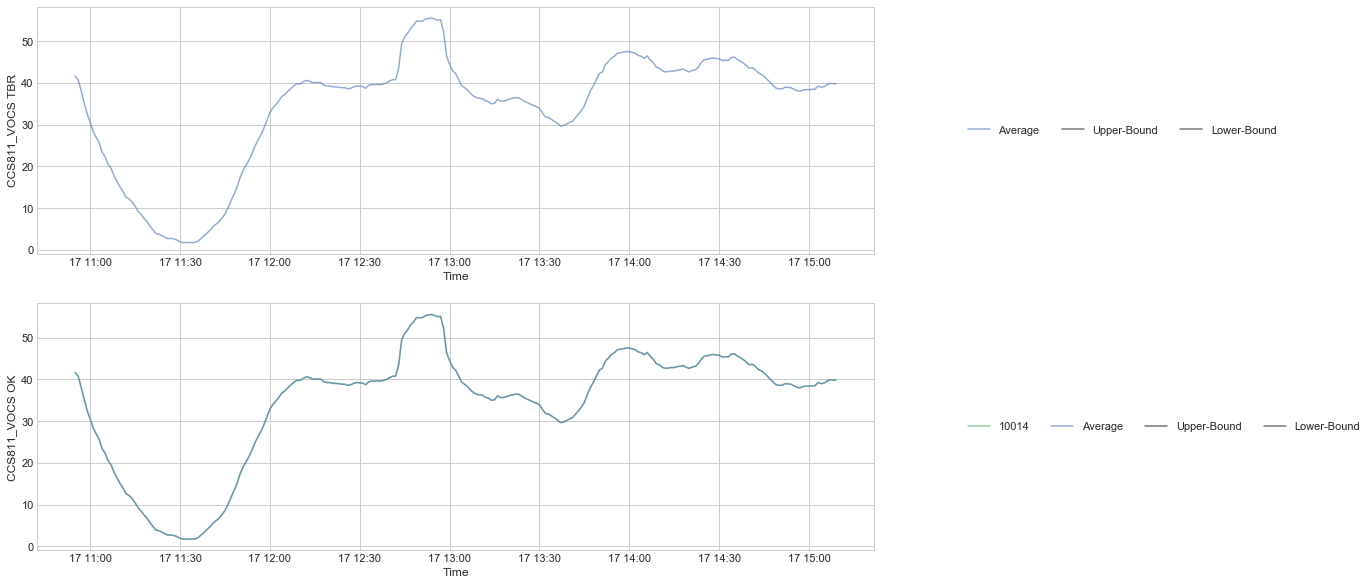

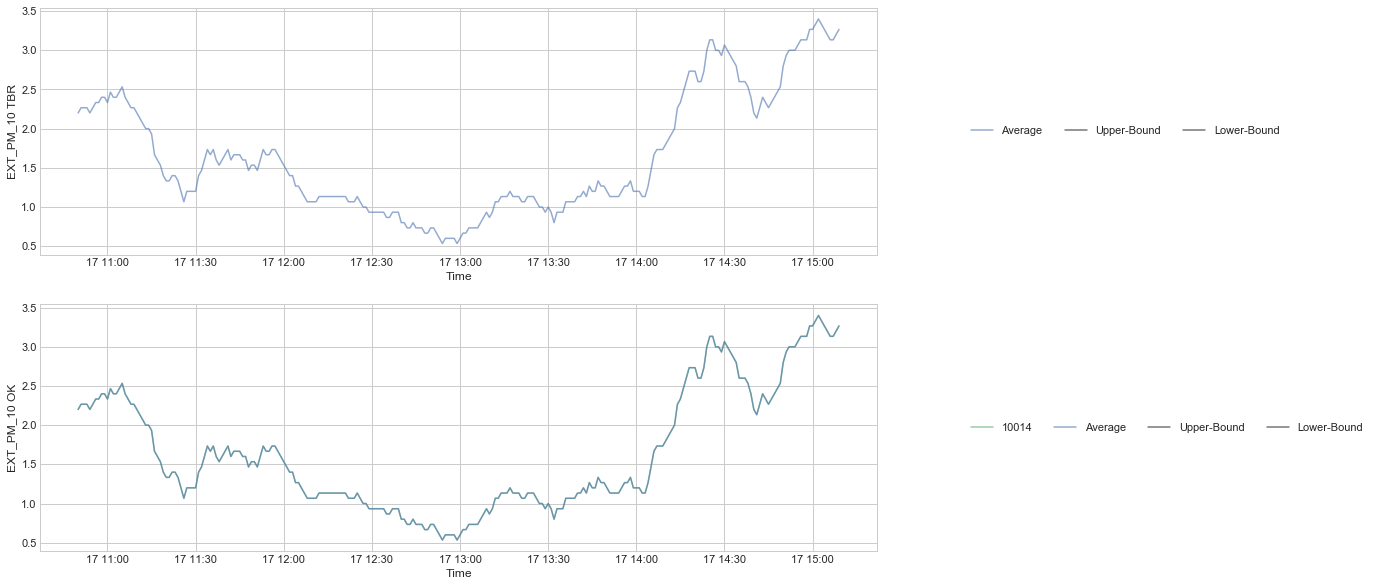

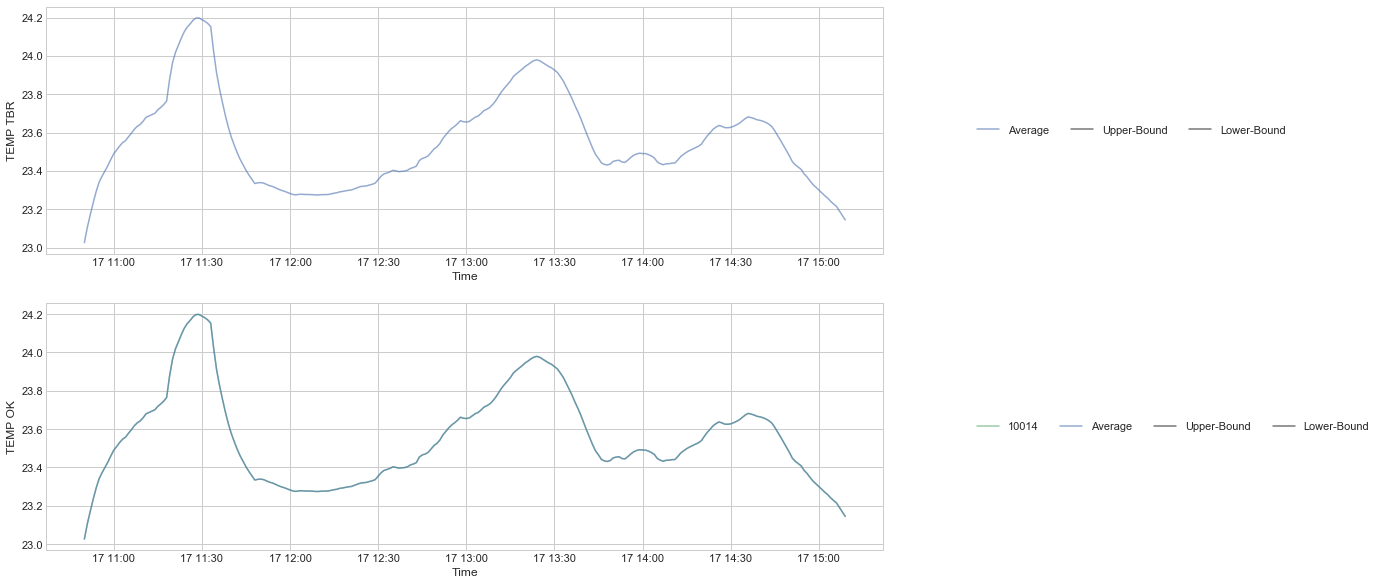

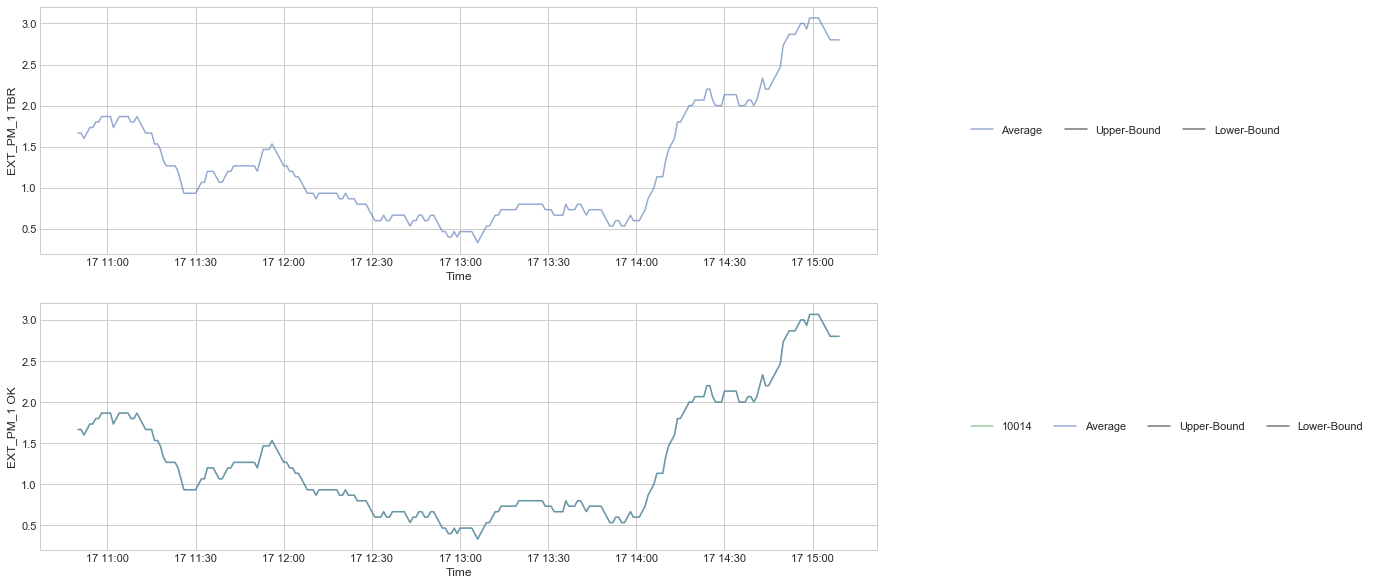

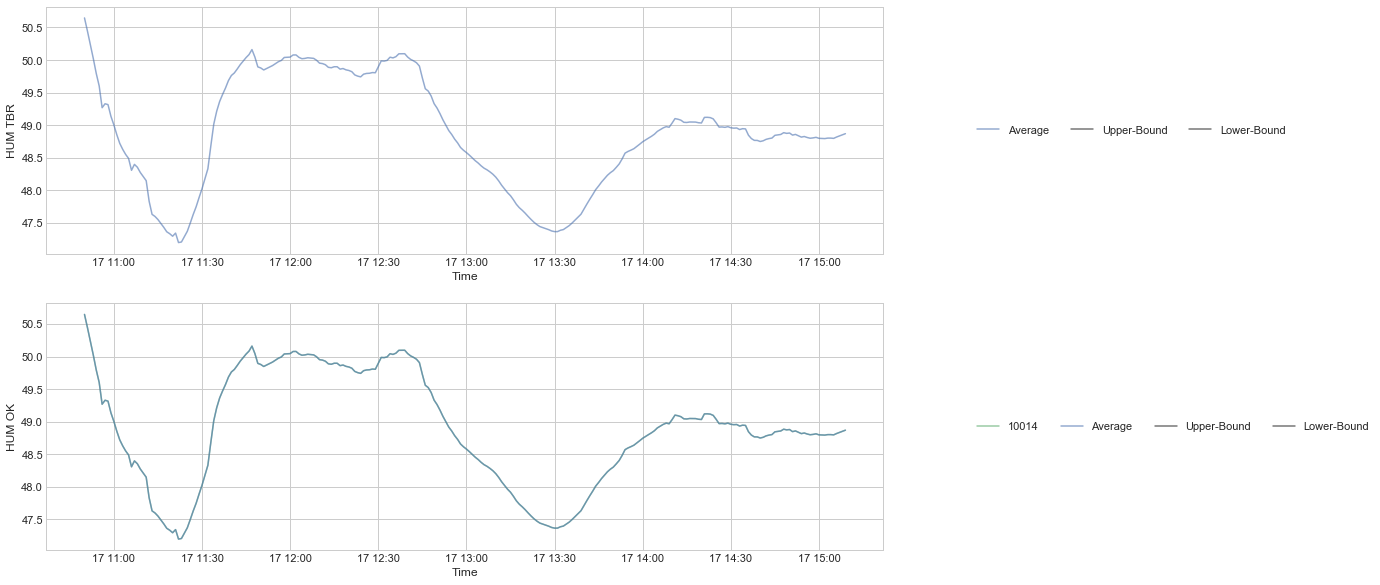

In [8]:
display(HTML('<h2>Time Series Plots</h2>'))
display(HTML('Min Date available: {}'.format(min_date)))
display(HTML('Max Date available: {}'.format(max_date)))
        
# Ignore battery
if 'BATT' in list_channels: list_channels.remove('BATT')
dict_devices_tbr = dict()
for item in list_channels: dict_devices_tbr[item] = list()

for channel in list_channels:
    # Make subplot
    list_columns = list()
    fig, (ax1, ax2) = plot.subplots(nrows = 2, figsize= (15,10))
    cmap = plot.cm.Reds
    norm = matplotlib.colors.Normalize(vmin=0, vmax=limit_errors/2)
    display(HTML('<h3>({}/{}) - {} </h3>'.format(list_channels.index(channel)+1, len(list_channels), channel)))
    
    dispersion_avg = 0
    limit_confidence_sigma = 0
    for item in dispersion_history:
        if channel == item[0]:
            dispersion_avg = item[1]
            limit_confidence_sigma = item[2]
    
    display(HTML('<p>Using limit for sigma confidence: {}'.format(limit_confidence_sigma)))
    dispersion_df[channel + '_MAX'] = dispersion_df.loc[:,list_columns].max(skipna=True, axis = 1)
    dispersion_df[channel + '_MIN'] = dispersion_df.loc[:,list_columns].min(skipna=True, axis = 1)
    
    # Calculate upper and lower bounds
    # print ('Calculating upper and lower bounds')
    if (use_instantatenous_dispersion):
        # For sensors with high variability in the measurements, it's better to use this (i.e. alphasense)
        upper_bound = dispersion_df[channel + '_AVG'] + limit_confidence_sigma * dispersion_df[channel + '_STD']
        lower_bound = dispersion_df[channel + '_AVG'] - abs(limit_confidence_sigma * dispersion_df[channel + '_STD'])
    else:
        upper_bound = dispersion_df[channel + '_AVG'] + limit_confidence_sigma * dispersion_avg
        lower_bound = dispersion_df[channel + '_AVG'] - abs(limit_confidence_sigma * dispersion_avg)
    
    # print ('Plotting devices')
    for device in list_devices:
        name_column = channel + '-' + device 
        if name_column in dispersion_df.columns:
            # Count how many times we go above the upper bound or below the lower one
            count_problems_up = dispersion_df[name_column] > upper_bound
            count_problems_down =  dispersion_df[name_column] < lower_bound
            
            # Count them
            count_problems = [1 if (count_problems_up[i] or count_problems_down[i]) else 0 for i in range(len(count_problems_up))]
            # print (channel, device, np.sum(count_problems), len(count_problems))

            # Add the trace in either
            number_errors = np.sum(count_problems)
            max_number_errors = len(count_problems)
            # print (number_errors, max_number_errors)
            if number_errors > max_number_errors/limit_errors:
                if device not in dict_devices_tbr[channel]: dict_devices_tbr[channel].append(device)
                alpha = 0.6
                ax1.plot(dispersion_df.index, 
                         dispersion_df[name_column], 
                         color = cmap(norm(number_errors/max_number_errors*limit_errors)),
                         label = device, alpha = alpha)
            else:
                alpha = 0.6
                color = 'g'
                ax2.plot(dispersion_df.index, 
                         dispersion_df[name_column], 
                         color = color, 
                         label = device, alpha = alpha)
        
    # Add upper and low bound bound to subplot 1
    ax1.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.6)
    ax1.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound', alpha = 0.6)
    ax1.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound', alpha = 0.6)
    
    # Format the legend
    lgd1 = ax1.legend(bbox_to_anchor=(1.1, 0.5), fancybox=True, loc='center left', ncol = 5)
    ax1.grid(True)
    ax1.set_ylabel(channel + ' TBR')
    ax1.set_xlabel('Time')
    
    # Add upper and low bound bound to subplot 2
    ax2.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.6)
    ax2.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound', alpha = 0.6)
    ax2.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound', alpha = 0.6)
    
    # Format the legend
    ax2.legend(bbox_to_anchor=(1.1, 0.5), fancybox=True, loc='center left', ncol = 5)
    lgd2 = ax2.legend(bbox_to_anchor=(1.1, 0.5), fancybox=True, loc='center left', ncol = 5)
    ax2.grid(True)
    ax2.set_ylabel(channel + ' OK')
    ax2.set_xlabel('Time')
    
    # Check file type to make the export
    if type_file is not None: print ('Saving figure')
    if type_file == 'fig':
        pickle.dump(fig, open(save_path + '/' + dispersion_test + '_' + channel + '.fig.pickle', 'wb'))
    elif type_file == 'png':
        fig.savefig(save_path + '/' + dispersion_test + '_' + channel + '.png', dpi=300, trasnparent = True, bbox_extra_artists=(lgd1, lgd2), bbox_inches='tight' )

    # Show plots     
    plot.show()
    display(HTML('<br>'))

### Summary

In [9]:
summary_df = pd.DataFrame(columns= {'#_TBR_DEVICES', '#_OK_DEVICES', 'DISPERSION'}, index = list_channels)

for item in dispersion_history:
    summary_df.loc[item[0], 'DISPERSION'] = item[1]
    if item[0] != 'BATT':
        summary_df.loc[item[0], '#_TBR_DEVICES'] = len(dict_devices_tbr[item[0]])
        summary_df.loc[item[0], '#_OK_DEVICES'] = len(list_devices) - len(dict_devices_tbr[item[0]])
    
display (summary_df)

,#_TBR_DEVICES,#_OK_DEVICES,DISPERSION
EXT_PM_25,0,1,NaN
CCS811_ECO2,0,1,NaN
NOISE_A,0,1,NaN
LIGHT,0,1,NaN
PRESS,0,1,NaN
CCS811_VOCS,0,1,NaN
EXT_PM_10,0,1,NaN
TEMP,0,1,NaN
EXT_PM_1,0,1,NaN
HUM,0,1,NaN
